# UTSC Machine Learning WorkShop
## Cross-validation for parameter tuning, model selection, and feature selection
*From the video series: [Introduction to machine learning with scikit-learn](https://github.com/justmarkham/scikit-learn-videos)*

## Agenda

- What is the drawback of using the **train/test split** procedure for model evaluation?
- How does **K-fold cross-validation** overcome this limitation?
- How can cross-validation be used for selecting **tuning parameters**, choosing between **models**, and selecting **features**?
- What are some possible **improvements** to cross-validation?
- How to ensure cross-validation is correctly done. 

## Review of model evaluation procedures

**Motivation:** Need a way to choose between machine learning models

- Goal is to estimate likely performance of a model on **out-of-sample data**

**Initial idea:** Train and test on the same data

- But, maximizing **training accuracy** rewards overly complex models which **overfit** the training data

**Alternative idea:** Train/test split

- Split the dataset into two pieces, so that the model can be trained and tested on **different data**
- **Testing accuracy** is a better estimate than training accuracy of out-of-sample performance
- But, it provides a **high variance** estimate since changing which observations happen to be in the testing set can significantly change testing accuracy

In [24]:
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [25]:
# read in the iris data
iris = load_iris()

# create X (features) and y (response)
X = iris.data
y = iris.target

In [26]:
# use train/test split with different random_state values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

# check classification accuracy of KNN with K=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print metrics.accuracy_score(y_test, y_pred)

0.973684210526


**Question:** What if we created a bunch of train/test splits, calculated the testing accuracy for each, and averaged the results together?

**Answer:** That's the essense of cross-validation!

## Steps for K-fold cross-validation

1. Split the dataset into K **equal** partitions (or "folds").
2. Use fold 1 as the **testing set** and the union of the other folds as the **training set**.
3. Calculate **testing accuracy**.
4. Repeat steps 2 and 3 K times, using a **different fold** as the testing set each time.
5. Use the **average testing accuracy** as the estimate of out-of-sample accuracy.

Diagram of **5-fold cross-validation:**

![5-fold cross-validation](images/07_cross_validation_diagram.png)

In [27]:
# simulate splitting a dataset of 25 observations into 5 folds
from sklearn.cross_validation import KFold
kf = KFold(25, n_folds=5, shuffle=False)

# print the contents of each training and testing set
print '{} {:^61} {}'.format('Iteration', 'Training set observations', 'Testing set observations')
for iteration, data in enumerate(kf, start=1):
    print '{:^9} {} {:^25}'.format(iteration, data[0], data[1])

Iteration                   Training set observations                   Testing set observations
    1     [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [0 1 2 3 4]       
    2     [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [5 6 7 8 9]       
    3     [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22 23 24]     [10 11 12 13 14]     
    4     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 22 23 24]     [15 16 17 18 19]     
    5     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]     [20 21 22 23 24]     


- Dataset contains **25 observations** (numbered 0 through 24)
- 5-fold cross-validation, thus it runs for **5 iterations**
- For each iteration, every observation is either in the training set or the testing set, **but not both**
- Every observation is in the testing set **exactly once**

## Comparing cross-validation to train/test split

Advantages of **cross-validation:**

- More accurate estimate of out-of-sample accuracy
- More "efficient" use of data (every observation is used for both training and testing)

Advantages of **train/test split:**

- Runs K times faster than K-fold cross-validation
- Simpler to examine the detailed results of the testing process

## Cross-validation recommendations

1. K can be any number, but **K=10** is generally recommended
2. For classification problems, **stratified sampling** is recommended for creating the folds
    - Each response class should be represented with equal proportions in each of the K folds
    - scikit-learn's `cross_val_score` function does this by default

## Cross-validation example: parameter tuning

**Goal:** Select the best tuning parameters (aka "hyperparameters") for KNN on the iris dataset

In [28]:
from sklearn.cross_validation import cross_val_score

In [29]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print scores

[ 1.          0.93333333  1.          1.          0.86666667  0.93333333
  0.93333333  1.          1.          1.        ]


In [30]:
# use average accuracy as an estimate of out-of-sample accuracy
print scores.mean()

0.966666666667


In [31]:
# search for an optimal value of K for KNN
k_range = range(1, 31)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print k_scores

[0.95999999999999996, 0.95333333333333337, 0.96666666666666656, 0.96666666666666656, 0.96666666666666679, 0.96666666666666679, 0.96666666666666679, 0.96666666666666679, 0.97333333333333338, 0.96666666666666679, 0.96666666666666679, 0.97333333333333338, 0.98000000000000009, 0.97333333333333338, 0.97333333333333338, 0.97333333333333338, 0.97333333333333338, 0.98000000000000009, 0.97333333333333338, 0.98000000000000009, 0.96666666666666656, 0.96666666666666656, 0.97333333333333338, 0.95999999999999996, 0.96666666666666656, 0.95999999999999996, 0.96666666666666656, 0.95333333333333337, 0.95333333333333337, 0.95333333333333337]


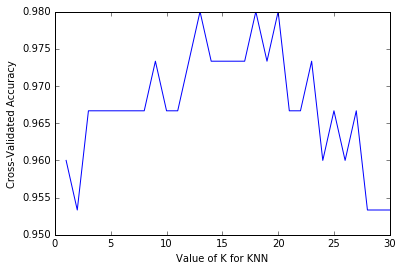

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

## Cross-validation example: model selection

**Goal:** Compare the best KNN model with logistic regression on the iris dataset

In [33]:
# 10-fold cross-validation with the best KNN model
knn = KNeighborsClassifier(n_neighbors=20)
print cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean()

0.98


In [34]:
# 10-fold cross-validation with logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
print cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean()

0.953333333333


## Cross-validation example: feature selection

**Goal**: Select whether the Newspaper feature should be included in the linear regression model on the advertising dataset

In [35]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression

In [36]:
# read in the advertising dataset
data = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)

In [37]:
# create a Python list of three feature names
feature_cols = ['TV', 'Radio', 'Newspaper']

# use the list to select a subset of the DataFrame (X)
X = data[feature_cols]

# select the Sales column as the response (y)
y = data.Sales

In [38]:
# 10-fold cross-validation with all three features
lm = LinearRegression()
scores = cross_val_score(lm, X, y, cv=10, scoring='mean_squared_error')
print scores

[-3.56038438 -3.29767522 -2.08943356 -2.82474283 -1.3027754  -1.74163618
 -8.17338214 -2.11409746 -3.04273109 -2.45281793]


In [39]:
# fix the sign of MSE scores
mse_scores = -scores
print mse_scores

[ 3.56038438  3.29767522  2.08943356  2.82474283  1.3027754   1.74163618
  8.17338214  2.11409746  3.04273109  2.45281793]


In [40]:
# convert from MSE to RMSE
rmse_scores = np.sqrt(mse_scores)
print rmse_scores

[ 1.88689808  1.81595022  1.44548731  1.68069713  1.14139187  1.31971064
  2.85891276  1.45399362  1.7443426   1.56614748]


In [41]:
# calculate the average RMSE
print rmse_scores.mean()

1.69135317081


In [42]:
# 10-fold cross-validation with two features (excluding Newspaper)
feature_cols = ['TV', 'Radio']
X = data[feature_cols]
print np.sqrt(-cross_val_score(lm, X, y, cv=10, scoring='mean_squared_error')).mean()

1.67967484191


## Improvements to cross-validation

**Repeated cross-validation**

- Repeat cross-validation multiple times (with **different random splits** of the data) and average the results
- More reliable estimate of out-of-sample performance by **reducing the variance** associated with a single trial of cross-validation

**Creating a hold-out set**

- "Hold out" a portion of the data **before** beginning the model building process
- Locate the best model using cross-validation on the remaining data, and test it **using the hold-out set**
- More reliable estimate of out-of-sample performance since hold-out set is **truly out-of-sample**

**Feature engineering and selection within cross-validation iterations**

- Normally, feature engineering and selection occurs **before** cross-validation
- Instead, perform all feature engineering and selection **within each cross-validation iteration**
- More reliable estimate of out-of-sample performance since it **better mimics** the application of the model to out-of-sample data

## The right and wrong ways to do cross validation

Adapted from Havard CS 109 class. 

### The scenario

You have 20 datapoints, each of which has 1,000,000 attributes. Each observation also has an associated $y$ value, and you are interested in whether a linear combination of a few attributes can be used to predict $y$. That is, you are looking for a model

$$
y_i \sim \sum_j w_j x_{ij}
$$

where most of the 1 million $w_j$ values are 0.

### The problem

Since there are so many more attributes than datapoints, the chance that a few attributes correlate with $y$ by pure coincidence is fairly high. 

You kind of remember that cross-validation helps you detect over-fitting, but you're fuzzy on the details.

### The wrong way to cross-validate

* Determine a few attributes of X that correlate well with Y
* Use cross-validation to measure how well a linear fit to these attributes predicts y

In [43]:
#Let's make a data set and compute "y" with the hidden_model. 
#from sklearn.feature_selection import SelectKBest, f_regression
def hidden_model(x):
    #y is a linear combination of columns 5 and 10...
    result = x[:, 5] + x[:, 10]
    #... with a little noise
    result += np.random.normal(0, .005, result.shape)
    return result
    
    
def make_x(nobs):
    return np.random.uniform(0, 3, (nobs, 10 ** 6))

x = make_x(20)
y = hidden_model(x)

print(x.shape)

(20, 1000000)


We use scikit-learn's feature selection method to tell us about the two features correlated best with y.

In [44]:
selector = SelectKBest(f_regression, k=2).fit(x, y)
best_features = np.where(selector.get_support())[0]
print(best_features)

[401281 832578]


We've selected 2 columns which correlate with Y by chance, but neither of which are columns 5 or 10 (the only 2 columns that *actually* have anything to do with y). We can look at the correlations between these columns and Y, and confirm they are pretty good (again, just a coincidence):

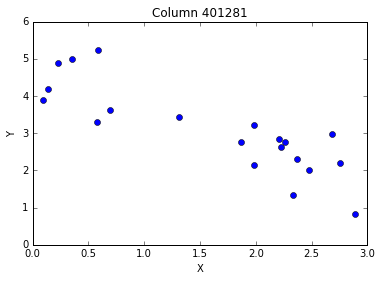

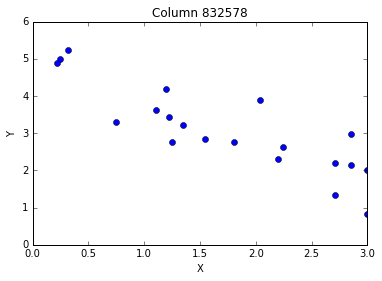

In [46]:
for b in best_features:
    plt.plot(x[:, b], y, 'o')
    plt.title("Column %i" % b)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

A linear regression on the full data looks good. The "score" here is the $R^2$ score -- scores close to 1 imply a good fit.

In [47]:
xt = x[:, best_features]
clf = LinearRegression().fit(xt, y)
print("Score is ", clf.score(xt, y))

('Score is ', 0.82553065737393228)


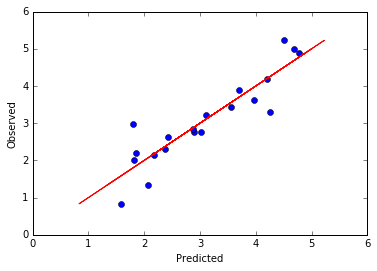

In [48]:
yp = clf.predict(xt)
plt.plot(yp, y, 'o')
plt.plot(y, y, 'r-')
plt.xlabel("Predicted")
plt.ylabel("Observed")

We're worried about overfitting, and remember that cross-validation is supposed to detect this. Let's look at the average $R^2$ score, when performing 5-fold cross validation. It's not as good, but still not bad...

In [49]:
cross_val_score(clf, xt, y, cv=5).mean()

0.43411312410856356

And even if we make some plots of the predicted and actual data at each cross-validation iteration, the model seems to predict the "independent" data pretty well...

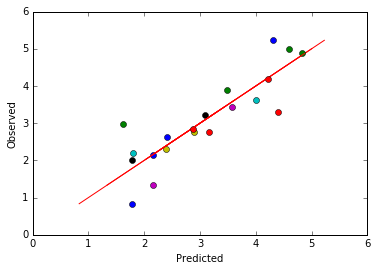

In [50]:
for train, test in KFold(len(y), 10):
    xtrain, xtest, ytrain, ytest = xt[train], xt[test], y[train], y[test]

    clf.fit(xtrain, ytrain)
    yp = clf.predict(xtest)
    
    plt.plot(yp, ytest, 'o')
    plt.plot(ytest, ytest, 'r-')
    

plt.xlabel("Predicted")
plt.ylabel("Observed")

However, this is not the case if we generate more data. 

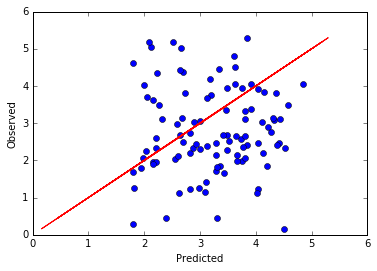

In [51]:
x2 = make_x(100)
y2 = hidden_model(x2)
x2 = x2[:, best_features]

y2p = clf.predict(x2)

plt.plot(y2p, y2, 'o')
plt.plot(y2, y2, 'r-')
plt.xlabel("Predicted")
plt.ylabel("Observed")

Cross-validation did not detect the overfitting, because we used the entire data to select "good" features.

## The right way to cross-validate

To prevent overfitting, we can't let *any* information about the full dataset leak into cross-validation. Thus, we must re-select good features in each cross-validation iteration

('CV Score is ', -1.5536551419896845)


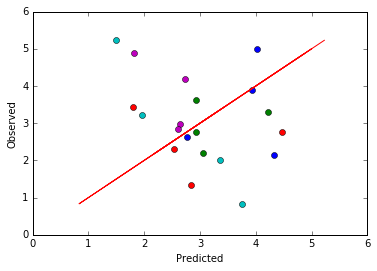

In [52]:
scores = []

for train, test in KFold(len(y), n_folds=5):
    xtrain, xtest, ytrain, ytest = x[train], x[test], y[train], y[test]
    
    b = SelectKBest(f_regression, k=2)
    b.fit(xtrain, ytrain)
    xtrain = xtrain[:, b.get_support()]
    xtest = xtest[:, b.get_support()]
    
    clf.fit(xtrain, ytrain)    
    scores.append(clf.score(xtest, ytest))

    yp = clf.predict(xtest)
    plt.plot(yp, ytest, 'o')
    plt.plot(ytest, ytest, 'r-')
    
plt.xlabel("Predicted")
plt.ylabel("Observed")

print("CV Score is ", np.mean(scores))

Now cross-validation properly detects overfitting, by reporting a low average $R^2$ score and a plot that looks like noise. Of course, it doesn't help us actually *discover* the fact that columns 5 and 10 determine Y (this task is probably hopeless without more data) -- it just lets us know when our fitting approach isn't generalizing to new data.

## Resources

- scikit-learn documentation: [Cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html), [Model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html)
- scikit-learn issue on GitHub: [MSE is negative when returned by cross_val_score](https://github.com/scikit-learn/scikit-learn/issues/2439)
- Section 5.1 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) (11 pages) and related videos: [K-fold and leave-one-out cross-validation](https://www.youtube.com/watch?v=nZAM5OXrktY) (14 minutes), [Cross-validation the right and wrong ways](https://www.youtube.com/watch?v=S06JpVoNaA0) (10 minutes)
- Scott Fortmann-Roe: [Accurately Measuring Model Prediction Error](http://scott.fortmann-roe.com/docs/MeasuringError.html)
- Machine Learning Mastery: [An Introduction to Feature Selection](http://machinelearningmastery.com/an-introduction-to-feature-selection/)
- Harvard CS109: [Cross-Validation: The Right and Wrong Way](https://github.com/cs109/content/blob/master/lec_10_cross_val.ipynb)
- Journal of Cheminformatics: [Cross-validation pitfalls when selecting and assessing regression and classification models](http://www.jcheminf.com/content/pdf/1758-2946-6-10.pdf)

## Comments or Questions?

- Email: <kevin@dataschool.io>
- Website: http://dataschool.io
- Twitter: [@justmarkham](https://twitter.com/justmarkham)

In [20]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()